# Example of using `infant_tools` to work with database.
content:
+ loading all data in database as `data_dict` structure
+ filtering recordings based on their duration
+ plotting recordings durations
+ pipeline for counting number of touches
+ plotting number of touches
+ extraction of touch duration and pauses between touches

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import infant_tools.load_data as load_data
import infant_tools.timeseries as timeseries
import infant_tools.plotting as plotting

%matplotlib inline
# !! after changing infant_tools resources kernel need to be restarted !! 

## Define constant parameters

In [19]:
# format of time series data
NO_TOUCH = "NONE"
HELP = "HELP"
RH = "RH"
LH = "LH"
INFANTS = ["AA", "TH", "CA", "RT"]

# paths to data
framerate_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/SELF_TOUCH_TIMESERIES/framerate.csv"
data_path = "/home/jur0/LAB/main/self-touch-sequence-models/data/SELF_TOUCH_TIMESERIES"



# definition of touched areas
# without "back" labels
LOCATIONS = ['1L', '1R','2L', '2R','3L','3R', '4L', '4R', '5L', '5R','6L', '6R', '7L', '7R', '8L',
 '8R','9L','9R','10L','10R','11L','11R','13L','13R','16L','16R','17L','17R']

# older recordings were coded with higher spatial resolution, therefore we need to define how to merge these areas  
LOCATIONS_SIMPLIFICATION = {"13L": ["13L", "15L"], "13R": ["13R", "15R"], "11L":["11L", "12L", "14L"], "11R":["11R", "12R", "14R"]}

## Load data

### loading only one recording can be done using `pandas` library

In [23]:
# define recording 
recording_path = os.path.join(data_path, "AA", "11w", "AA_st-2_s_s02_11w-3d_supine", "spatiotemporal.csv")
data = pd.read_csv(recording_path, sep="\t")
data

Unnamed: 0    RH    LH
0              0  NONE  NONE
1              1  NONE  NONE
2              2  NONE  NONE
3              3  NONE  NONE
4              4  NONE  NONE
...          ...   ...   ...
2644        2644  NONE  HELP
2645        2645  NONE  HELP
2646        2646  NONE  HELP
2647        2647  NONE  HELP
2648        2648  NONE  HELP

[2649 rows x 3 columns]

### loading the whole time series dataset

data are loaded into two variables with the same structure (corresponding to database folder structure): `{infant:{week:[recording1, recording2, ..]}}` 
+   `data_dict` contains  _spatiotemporal.csv_ (from time series database) as `pandas.DataFrame` 
+   `filename_dict` contains recordings names

In [24]:
data_dict, filename_dict = load_data.get_all_data(data_path)
filename_dict

{'AA': {'11w': ['AA_st-3_s_s02_11w-3d_supine', 'AA_st-2_s_s02_11w-3d_supine']},
 'TH': {'27w': ['TH_st_s_28_27w-6d_supine']},
 'CA': {'20w': ['CA_st-1_s_s06_20w-0d_supine']},
 'RT': {'17w': ['RT_st_s_s02_17w-0d_supine']}}

### Filtering recordings

recordings can be filtered by user defined function, which is applied to all values in dataset structured variable (`data_dict`, `filename_dict`, ..).
The most obvious reason for filtering is to exclude short recordings or exclude recordings with little activity (by specifying min number of touches) 



In [25]:
# filter by recording duration

threshold_duration = 500 # s

filename_dict, data_dict, video_length_dict = load_data.filter_data(filename_dict, data_dict, load_data.get_video_length, threshold_duration, framerate_path)
video_length_dict

{'AA': {'11w': [842.4]},
 'TH': {'27w': [641.76]},
 'CA': {'20w': [976.816667]},
 'RT': {'17w': [623.72]}}

new filtered `filename_dict`, `data_dict` are created together with `video_length_dict` - output of filter function: `load_data.get_video_length`

`filename_dict`, `data_dict`, are in the same format, but without excluded recordings by filter function 

### create figure

(0.0, 1300.0)

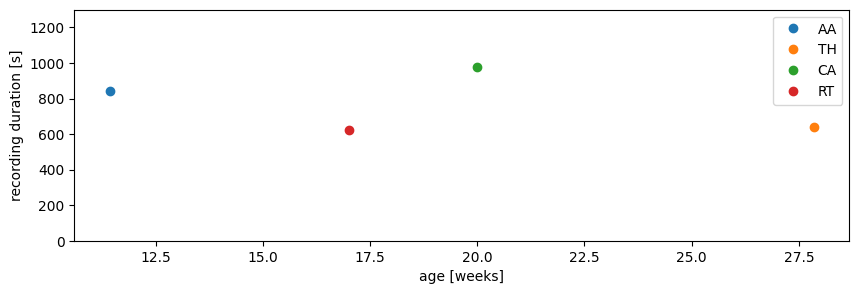

In [26]:
# easy plotting of data in dictionary
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 3))

plotting.plot_data_dict(video_length_dict, filename_dict, "recording duration [s]", ax=ax, marker="o", linestyle="none")

ax.set_ylim([0, 1300])

## Counting touches - basic pipeline for working with the data 

Function `load_data.apply_data_dict_function` is used to apply user defined function / `pipeline` to each value in variable with database structure (`data_dict`, `filename_dict`,...). 

> Note that each touched area within a complex touch is considered as a separate touch, therefore the results in this example do not correspond to the real number of touches (and depends on the defined resolution of infant body map). 

define `pipeline`:
+ convert `pandas.DataFrame` to `numpy.ndarray`
+ edit areas as needed 
+ split data into parts based on `HELP` during recording 
+ each part is converted into `actions` time series, where durations of all states (touched areas, NONE state) are neglected
+ count number of touches 

In [27]:
def pipeline(data):
    # data is the loaded time series as pandas.DataFrame (values of data_dict)
    touches_count = 0
    for hand in [RH, LH]:
        # convert to numpy
        tm = data[hand].to_numpy()
        # in this example convert all 'back' areas to front areas
        tm = timeseries.back2normal(tm)
        # merge locations as needed
        tm = timeseries.merge_locations(tm, LOCATIONS_SIMPLIFICATION)
        # split time series into parts based on help
        tm_parts = timeseries.split_timeseries_by_help(tm, HELP)
        # iterate over parts of time series
        for tm_i in tm_parts:
            actions = timeseries.get_actions_timeseries(tm_i)
            # delete NONE state
            touches = timeseries.remove_no_touch(actions, NO_TOUCH)
            touches_count += len(touches)
    
    return touches_count

apply pipeline to each recording `data_dict` 

In [28]:
number_of_touches_dict = load_data.apply_data_dict_function(data_dict, pipeline)

<Axes: xlabel='age [weeks]', ylabel='number of touches'>

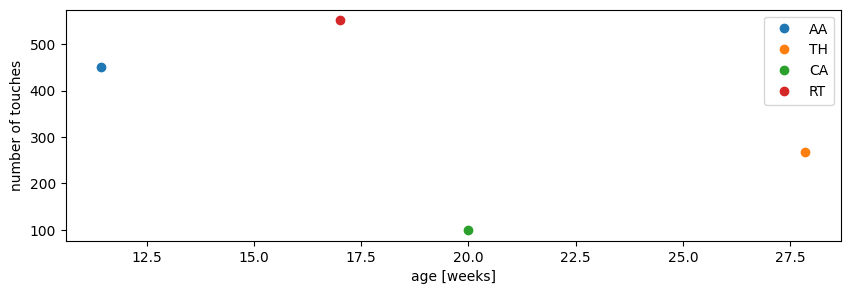

In [29]:
# easy plotting of data in dictionary
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 3))
plotting.plot_data_dict(number_of_touches_dict, filename_dict, "number of touches", ax=ax, marker="o", linestyle="none")

In [33]:
# now recordings can be filtered based on number of touches
touches_threshold = 150
new_data_dict, new_filename_dict, number_of_touches_dict = load_data.filter_data(data_dict, filename_dict, pipeline, touches_threshold)


## Average duration of touches, average duration of pauses between touches (simplified)

in this example, a simplified extractions of touches duration will be shown. Note that this approach does not reveal the real duration of touches, for two reasons:
+ each area touched during complex touch will be considered as "a new touch"
+ the durations of area contact within complex touch is uniformly distributed

The first problem could be solved by code, however the second problem comes from manually coded data (no information about onsets and offsets within complex touch provided).

Function `get_actions_count` returns the number of frames per each touched area. The values can be mapped to the output of `get_actions_timeseries`, if `NO_TOUCH` is removed. 

---

In addition a simplified extractions of durations between touches will be shown. In this case the number of frames with "no activity" between touches is retrieved.

Function `get_pauses_between_touches` returns the number of frames between touched ares. 0 values correspond to the transitions within complex touch.

In [34]:
def pipeline_average_touches_durations(data, filename):
    framerate = load_data.get_video_framerate(filename, framerate_path)

    touches_durations = []
    for hand in [RH, LH]:
        # convert to numpy
        tm = data[hand].to_numpy()
        # in this example convert all 'back' areas to front areas
        tm = timeseries.back2normal(tm)
        # merge locations as needed
        tm = timeseries.merge_locations(tm, LOCATIONS_SIMPLIFICATION)
        # split time series into parts based on help
        tm_parts = timeseries.split_timeseries_by_help(tm, HELP)
        # iterate over parts of time series
        for tm_i in tm_parts:
            # get duration of touches and concatenate
            touches_durations += list(timeseries.get_actions_count(tm_i, NO_TOUCH))
    
    return np.mean(touches_durations)/framerate # average touch duration in seconds

In [35]:
average_touch_duration = load_data.apply_data_dict_function(data_dict, pipeline_average_touches_durations, filename_dict=filename_dict)

In [36]:
def pipeline_average_pauses_durations(data, filename):
    framerate = load_data.get_video_framerate(filename, framerate_path)

    pauses_durations = []
    for hand in [RH, LH]:
        # convert to numpy
        tm = data[hand].to_numpy()
        # in this example convert all 'back' areas to front areas
        tm = timeseries.back2normal(tm)
        # merge locations as needed
        tm = timeseries.merge_locations(tm, LOCATIONS_SIMPLIFICATION)
        # split time series into parts based on help
        tm_parts = timeseries.split_timeseries_by_help(tm, HELP)
        # iterate over parts of time series
        for tm_i in tm_parts:
            # get duration of pauses and concatenate
            pauses_durations += list(timeseries.get_pauses_between_touches(tm_i, NO_TOUCH))
    
    pauses_durations = np.array(pauses_durations)

    # remove pauses with value 0 : corresponds to transitions within complex touch
    pauses_durations = pauses_durations[np.where(pauses_durations != 0)]
    return np.mean(pauses_durations)/framerate # average touch duration in seconds

In [37]:
average_pause_duration = load_data.apply_data_dict_function(data_dict, pipeline_average_pauses_durations, filename_dict=filename_dict)

(0.0, 11.0)

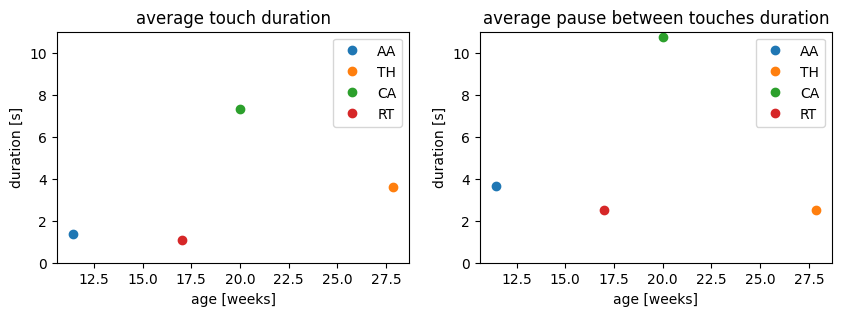

In [40]:
# easy plotting of data in dictionary
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 3))
plotting.plot_data_dict(average_touch_duration, filename_dict, "duration [s]", ax=axes[0], marker="o", linestyle="none")
axes[0].set_title("average touch duration")

plotting.plot_data_dict(average_pause_duration, filename_dict, "duration [s]", ax=axes[1], marker="o", linestyle="none")
axes[1].set_title("average pause between touches duration")

axes[0].set_ylim([0, 11])
axes[1].set_ylim([0, 11])

To elaborate more on how to extract touched areas, corresponding durations of contact, and duration of pauses between these touches; a code snippet with an example time series is provided.  

In [16]:
tm = np.array([NO_TOUCH, NO_TOUCH, "5R", "5R", "5R", NO_TOUCH, NO_TOUCH, NO_TOUCH, "6R", "6R", "6L", "6L", NO_TOUCH,NO_TOUCH])

# neglect the durations of each state -> actions
actions = timeseries.get_actions_timeseries(tm)
# keep only sequence of touched areas
locations = timeseries.remove_no_touch(actions, NO_TOUCH)

# get durations (in frames) of touched areas
durations = timeseries.get_actions_count(tm, NO_TOUCH)
# get durations between touched areas
pauses = timeseries.get_pauses_between_touches(tm, NO_TOUCH)

In [17]:
print("locations: {}\ndurations: {}\npauses: {}".format(locations, durations, pauses)) 

locations: ['5R' '6R' '6L']
durations: [3 2 2]
pauses: [3, 0]
